In [42]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import glob as glob
import os
%matplotlib inline
import warnings
from matplotlib.ticker import FormatStrFormatter
warnings.filterwarnings('ignore')

# Cost of Decoupled Namespace

1 server 1 client

In [43]:
def to_seconds(timestamp):
    ts = timestamp.split(':')
    try: return float(float(ts[0])*60*60 + float(ts[1])*60 + float(ts[2]))
    except: return float(0)

In [44]:
def mdtest(fname):
    with open(fname) as f:
        start = end = ""
        data = json.load(f)
        for line in data['stdout_lines']:
            if "started" in line: start = line.split()[4]
            if "finished" in line: end = line.split()[4]
        result = to_seconds(end) - to_seconds(start)
        if result < 0: return 0
        return result    

   nfiles      time       size
0      10  17:28:21      31827
2     100  17:59:46     240807
4    1000  18:31:01    2331507
6   10000  19:03:07   23247507
8  100000  19:36:25  232497507
2.38418579102
2.86102294922e-05


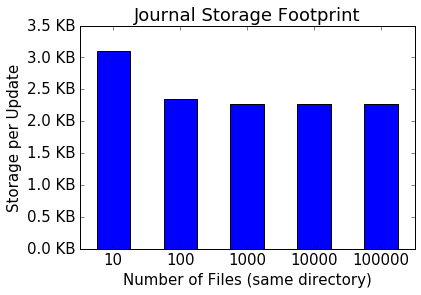

In [45]:
df = pd.DataFrame(columns=['nfiles', 'time', 'size'])

exp = "experiments/fuse/batchfs/results-all/results-run0/*/fsize.txt"
for fname in sorted(glob.glob(exp)):
    with open(fname) as f:
        d = pd.read_csv(f, names=['nfiles', 'time', 'size'])
        d['size'] = d['size']
        df = df.append(d, ignore_index=True)

df = df.drop_duplicates('nfiles')
print df
fig, ax = plt.subplots(1, 1)
df['norm'] = df['size']/(1024*df['nfiles'])
df.plot.bar(x='nfiles', y='norm', ax=ax)
ax.set_title("Journal Storage Footprint")
ax.set_xticklabels([10, 100, 1000, 10000, 100000], rotation=0)
ax.set_xlabel("Number of Files (same directory)")
ax.set_ylabel("Storage per Update")
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f KB'))
ax.legend().remove()
#ax.legend(fontsize=11, loc='lower right', ncol=2)
font = {'size'   : 15}
matplotlib.rc('font', **font)
fig.savefig('paper/graphs/behavior-journal-size.png', dpi=400)

print ((2.5)*1024*1000000)/(1024*1024*1024)
print ((2.5)*1024*(10^6))/(1024*1024*1024)



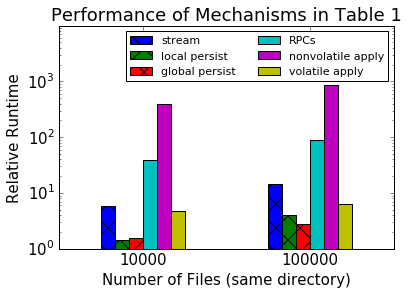

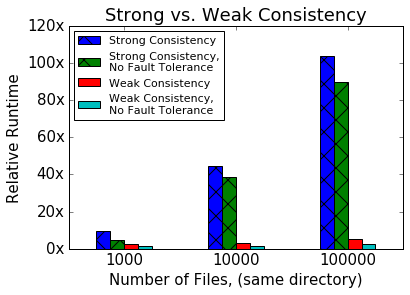

In [46]:
fig, ax = plt.subplots(1, 1)
exp   = "experiments/fuse/batchfs/results-all/"
runs  = ["run0"] #, "run1", "run2", "run3"]
jobs  = ['RPCs', 'create', 'save', 'persist', 'v.apply', 'apply']
#files = ['1000', '10000', '100000']
files = ['10000', '100000']

# get nostream
df = pd.DataFrame(columns=['job', 'nfile', 'rtime'])
for nfiles in files:
    for s in ["stream", "nostream"]:
        for run in runs:
            # parse the events execution times
            expdir = exp
            expdir += '/results-' + run 
            expdir += '/' + nfiles 
            with open(expdir + '/summary-' + s + '.txt') as f:
                d = pd.read_csv(f, names=['job', 'time', 'delta'])
                d['rtime'] = d['delta'].apply(to_seconds)
                d['nfile'] = np.full(len(d), nfiles)
                del d['time'], d['delta']
                d['job'] = d['job'] + '-' + s + '-' + run
                df = df.append(d, ignore_index=True)
            # parse the RPCs execution times
            df.loc[len(df)] = ["RPCs-" + s + '-' + run] + [float(nfiles)] + [mdtest(expdir + '/summary-rpcs-' + s + '.txt')]

# massage into graphable format
df = df.pivot(index='nfile', values='rtime', columns='job')
for j in jobs:
    for s in ["stream", "nostream"]:
        job = j + '-' + s
        dfs = [job + '-' + r for r in runs]
        df[j + '-' + s] = df[dfs].mean(axis=1)#

# calculate the phase execution times
x = ""
with open("experiments/transfertimes/results/dummy10k.txt") as f:
    for line in f:
        x = line
y = ""
with open("experiments/transfertimes/results/dummy100k.txt") as f:
    for line in f:
        y = line        
        
df['transfertime'] = [float(x), float(y)]
df['RPCs'] = df['RPCs-nostream']
df['stream'] = df['RPCs-stream'] - df['RPCs-nostream']
df['create'] = df['create-nostream']
df['local persist'] = df['save-nostream'] - df['create']
df['global persist'] = df['persist-nostream'] - df['create']
df['volatile apply'] = df['v.apply-nostream'] - df['create'] + df['transfertime']
df['nonvolatile apply'] = df['apply-nostream'] - df['create']

# prune
creates = df['create']
slowdowns = df[['stream', 'local persist', 'global persist', 'RPCs', 'nonvolatile apply', 'volatile apply']]
slowdowns = slowdowns[:].div(creates, axis=0)

# graph slowdowns
slowdowns.plot.bar(ax=ax)
#yerr=['10', '10', '10', '10', '10', '10', '100', '100', '100', '100', '100', '100', '10000', '10000', '10000', '10000', '10000', '10000', ])
ax.set_title("Performance of Mechanisms in Table 1")
ax.set_ylabel("Relative Runtime")
ax.set_xticklabels(files, rotation=0)
ax.set_xlabel("Number of Files (same directory)")
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0fx'))
ax.set_yscale('log')
ax.set_ylim([1,10**4])
ax.set_yticks([1, 10**1, 10**2, 10**3])

bars = ax.patches
hatches = ''.join(h*len(slowdowns) for h in 'xxx   ')
for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)
ax.legend(fontsize=11, loc='upper right', ncol=2)
font = {'size'   : 15}
matplotlib.rc('font', **font)

fig.savefig('paper/graphs/slowdown-mechanisms.png', bbox_inches='tight', dpi=400)
#############################################################################

fig, ax = plt.subplots(1, 1)

exp   = "experiments/fuse/batchfs/results-all/"
runs  = ["run0"] #, "run1", "run2", "run3"]
jobs  = ['RPCs', 'create', 'save', 'persist', 'v.apply', 'apply']
files = ['1000', '10000', '100000']

# get nostream
df = pd.DataFrame(columns=['job', 'nfile', 'rtime'])
for nfiles in files:
    for s in ["stream", "nostream"]:
        for run in runs:
            # parse the events execution times
            expdir = exp
            expdir += '/results-' + run 
            expdir += '/' + nfiles 
            with open(expdir + '/summary-' + s + '.txt') as f:
                d = pd.read_csv(f, names=['job', 'time', 'delta'])
                d['rtime'] = d['delta'].apply(to_seconds)
                d['nfile'] = np.full(len(d), nfiles)
                del d['time'], d['delta']
                d['job'] = d['job'] + '-' + s + '-' + run
                df = df.append(d, ignore_index=True)
            # parse the RPCs execution times
            df.loc[len(df)] = ["RPCs-" + s + '-' + run] + [float(nfiles)] + [mdtest(expdir + '/summary-rpcs-' + s + '.txt')]

# massage into graphable format
df = df.pivot(index='nfile', values='rtime', columns='job')
for j in jobs:
    for s in ["stream", "nostream"]:
        job = j + '-' + s
        dfs = [job + '-' + r for r in runs]
        df[j + '-' + s] = df[dfs].mean(axis=1)#

# calculate the phase execution times
df['RPCs'] = df['RPCs-nostream']
df['stream'] = df['RPCs-stream'] - df['RPCs-nostream']
df['create'] = df['create-nostream']
df['save'] = df['save-nostream'] - df['create']
df['persist'] = df['persist-nostream'] - df['create']
df['v.apply'] = df['v.apply-nostream'] - df['create']
df['apply'] = df['apply-nostream'] - df['create']

# prune
creates = df['create']
slowdowns = df[['v.apply', 'save', 'persist', 'stream', 'RPCs', 'apply']]
slowdowns = slowdowns[:].div(creates, axis=0)

# graph fair comparisons
fair = df
fair['RPCs+stream'] = df['RPCs'] + df['stream']
fair['create+persist+v.apply'] = creates + df['persist'] + df['v.apply']
fair['create+v.apply'] = creates + df['v.apply']
fair['RPCs'] = df['RPCs']

# normalize and graph
fair = fair[:].div(creates, axis=0)
fair['Strong Consistency'] = fair['RPCs+stream']
fair['Weak Consistency'] = fair['create+persist+v.apply']
fair['Strong Consistency,\nNo Fault Tolerance'] = fair['RPCs']
fair['Weak Consistency,\nNo Fault Tolerance'] = fair['create+v.apply']

fair = fair[['Strong Consistency',
              'Strong Consistency,\nNo Fault Tolerance', 
              'Weak Consistency',
              'Weak Consistency,\nNo Fault Tolerance', 
             ]]
fair.plot.bar(ax=ax)
ax.set_title("Strong vs. Weak Consistency")
ax.set_ylim(0)
ax.legend(fontsize=11, loc='upper left')
ax.set_ylim(0, 120)
ax.set_xticklabels(files, rotation=0)
ax.set_xlabel("Number of Files, (same directory)")
ax.set_ylabel("Relative Runtime")

ax.yaxis.set_major_formatter(FormatStrFormatter('%.0fx'))
bars = ax.patches
hatches = ''.join(h*len(slowdowns) for h in 'xx  ')
for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)
ax.legend(fontsize=11, loc='upper left', ncol=1)
font = {'size'   : 15}
matplotlib.rc('font', **font)
fig.savefig('paper/graphs/slowdown-strong-v-weak.png', dpi=400, bbox_inches='tight')



# Overhead of RPCs


In [47]:
print slowdowns['RPCs']/slowdowns['v.apply']
print slowdowns['apply']/slowdowns['RPCs']
print slowdowns['save']/slowdowns['persist']
slowdowns

nfile
1000      13.064381
10000     67.827738
100000    66.428664
dtype: float64
nfile
1000      12.807121
10000     10.456132
100000     9.674109
dtype: float64
nfile
1000      0.072021
10000     0.923857
100000    1.478801
dtype: float64


job,v.apply,save,persist,stream,RPCs,apply
nfile,,,,,,
1000,0.368067,0.090002,1.249656,4.808571,4.808571,61.583948
10000,0.565541,1.443523,1.562496,5.901446,38.359398,401.090918
100000,1.347355,4.079124,2.758400,14.239113,89.502994,865.861748


In [48]:
print fair['Strong Consistency']/fair['Eventual Consistency']
print fair['Strong Consistency,\nNo Fault Tolerance']/fair['Eventual Consistency,\nNo Fault Tolerance']

fair


KeyError: 'Eventual Consistency'

# Overhead of Strong Consistency

In [ ]:
print fair['Strong Consistency']/fair['Eventual Consistency']
print fair['Strong Consistency']/fair['Strong Consistency,\nNo Fault Tolerance']
print fair['Eventual Consistency']/fair['Eventual Consistency,\nNo Fault Tolerance']


In [ ]:


#slowdown_mean['RPCs'] = mean['RPCs']
#slowdown_mean.plot.bar(ax=ax)
#df['RPCs'] = df['RPCs-nostream']
#df['stream'] = df['RPCs-stream'] - df['RPCs-nostream']
#df['create'] = df['create-nostream']
#df['local persist'] = df['save-nostream'] - df['create']
#df['global persist'] = df['persist-nostream'] - df['create']
#df['volatile apply'] = df['v.apply-nostream'] - df['create']
#df['nonvolatile apply'] = df['apply-nostream'] - df['create']

#mean = pd.DataFrame()
#stds = pd.DataFrame()
#for j in jobs:
#    for s in ["stream", "nostream"]:
#        job = j + '-' + s
#        dfs = [job + '-' + r for r in runs]
#        try:
#            mean[job] = df[dfs].mean(axis=1)
#            stds[job] = df[dfs].std(axis=1)
#        except:
#            pass
#mean = mean.reset_index()
#stds = stds.reset_index()
#mean.plot.bar(ax=ax, yerr=stds)
#ax.set_title("Mechanisms in Table 1")
#ax.set_ylabel("Slowdown (Compared to Create)")
#ax.set_xticklabels(files, rotation=0)
#ax.set_xlabel("Number of Files")
#ax.yaxis.set_major_formatter(FormatStrFormatter('%.0fx'))
#ax.set_yscale('log')
#fig.savefig('paper/graphs/slowdown-mechanisms.png', dpi=400)

#bars = ax.patches
#hatches = ''.join(h*len(slowdowns) for h in 'xxx   ')
#for bar, hatch in zip(bars, hatches):
#    bar.set_hatch(hatch)
#ax.legend(fontsize=11, loc='lower right', ncol=2)
#font = {'size'   : 14}
#matplotlib.rc('font', **font)



# prune
#creates = df['create']
#slowdowns = df[['stream', 'local persist', 'global persist', 'RPCs', 'nonvolatile apply', 'volatile apply']]
#slowdowns = slowdowns[:].div(creates, axis=0)

In [ ]:
fig, ax = plt.subplots(1, 1)
exp   = "experiments/fuse/batchfs/results-all/"
runs  = ["run0", "run1", "run2", "run3"]
jobs  = ['RPCs', 'create', 'save', 'persist', 'v.apply', 'apply']
files = ['1000', '10000', '100000']

# get nostream
df = pd.DataFrame(columns=['job', 'nfile', 'rtime'])
for nfiles in files:
    for s in ["stream", "nostream"]:
        for run in runs:
            # parse the events execution times
            expdir = exp
            expdir += '/results-' + run 
            expdir += '/' + nfiles 
            with open(expdir + '/summary-' + s + '.txt') as f:
                d = pd.read_csv(f, names=['job', 'time', 'delta'])
                d['rtime'] = d['delta'].apply(to_seconds)
                d['nfile'] = np.full(len(d), nfiles)
                del d['time'], d['delta']
                d['job'] = d['job'] + '-' + s + '-' + run
                df = df.append(d, ignore_index=True)
            # parse the RPCs execution times
            df.loc[len(df)] = ["RPCs-" + s + '-' + run] + [float(nfiles)] + [mdtest(expdir + '/summary-rpcs-' + s + '.txt')]
            
# massage into graphable format
df = df.pivot(index='nfile', values='rtime', columns='job')
df = df.reset_index()

# calculate the phase execution times
mech = pd.DataFrame()
#for j in jobs:
#    for s in ["stream", "nostream"]:
#        job = j + '-' + s
#        dfs = [job + '-' + r for r in runs]
job = ['RPCs-nostream' + '-' + r for r in runs]
m = ['RPCs' + '-' + r for r in runs]
mech[m] = df[job]
#slowdown_mean['stream'] = mean['RPCs-stream'] - mean['RPCs-nostream']
#slowdown_mean['create'] = mean['create-nostream']

#mean = pd.DataFrame()
#stds = pd.DataFrame()
#mean['RPCs'] = mech[m].mean(axis=1)
#stds['RPCs'] = mech[m].std(axis=1)
#mean.plot.bar(ax=ax, yerr=stds)

